## Importación de librerías

In [1]:
# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras
print("Tensorflow version:", tf.__version__)
print("Keras version:", keras.__version__)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import time
import re

# Callbacks
from my_callbacks import TqdmProgressCallback, StopWhenValLossBelow, StopTrainingAtEpoch
from keras.callbacks import EarlyStopping

Tensorflow version: 2.20.0
Keras version: 3.13.2


## Carga de datos

In [2]:
ATT_FILE   = "FootballPlayerPreparedCleanAttributes.csv"
LABEL_FILE = "FootballPlayerOneHotEncodedClasses.csv"

TRAIN_RATE = 0.8

attributes = pd.read_csv(ATT_FILE)
label      = pd.read_csv(LABEL_FILE)

n_instances = attributes.shape[0]
n_train     = int(n_instances * TRAIN_RATE)
n_dev       = int((n_instances - n_train) / 2)

x_train = attributes.values[:n_train]
t_train = label.values[:n_train]

x_dev = attributes.values[n_train:n_train + n_dev]
t_dev = label.values[n_train:n_train + n_dev]

x_final_test = attributes.values[n_train + n_dev:n_instances]
t_final_test = label.values[n_train + n_dev:n_instances]

print("x_train     :", x_train.shape)
print("t_train     :", t_train.shape)
print("x_dev       :", x_dev.shape)
print("t_dev       :", t_dev.shape)
print("x_final_test:", x_final_test.shape)
print("t_final_test:", t_final_test.shape)

x_train     : (12907, 22)
t_train     : (12907, 4)
x_dev       : (1613, 22)
t_dev       : (1613, 4)
x_final_test: (1614, 22)
t_final_test: (1614, 4)


## Variables de forma

In [3]:
INPUTS  = x_train.shape[1]
OUTPUTS = t_train.shape[1]
NUM_TRAINING_EXAMPLES = x_train.shape[0]
NUM_DEV_EXAMPLES      = x_dev.shape[0]

print("Input features      :", INPUTS)
print("Output classes      :", OUTPUTS)
print("Training examples   :", NUM_TRAINING_EXAMPLES)
print("Development examples:", NUM_DEV_EXAMPLES)
print("Test examples       :", x_final_test.shape[0])

Input features      : 22
Output classes      : 4
Training examples   : 12907
Development examples: 1613
Test examples       : 1614


## Verificacion el orden de las etiquetas

In [4]:
# Verificar el orden real de las clases en el archivo de etiquetas
class_columns = pd.read_csv(LABEL_FILE).columns.tolist()
print("Orden real de las clases en el one-hot encoding:")
for i, col in enumerate(class_columns):
    print(f"  Índice {i} → {col}")
    
CLASS_NAMES = class_columns 

Orden real de las clases en el one-hot encoding:
  Índice 0 → Poor:[np.float64(46.0), np.float64(62.0)]
  Índice 1 → Interm:[np.float64(63.0), np.float64(66.0)]
  Índice 2 → Good:[np.float64(67.0), np.float64(71.0)]
  Índice 3 → Excel:[np.float64(72.0), np.float64(94.0)]


## Hiperparámetros

In [5]:
ACTIVATION_FUNCTION   = 'elu'
EPOCHS                = 1000
LEARNING_RATE         = 0.001
BATCH_SIZE            = 512
LAYER_NEURONS         = [64, 32, 16, 8]
OPTIMIZER             = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
REGULARIZATION_FACTOR = 0.0001
DROPOUT_RATES = [0.1, 0.0, 0.0, 0.0]

print("Configuración de hiperparámetros:")
print(f"  Activación       : {ACTIVATION_FUNCTION}")
print(f"  Épocas máximas   : {EPOCHS}")
print(f"  Learning Rate    : {LEARNING_RATE}")
print(f"  Batch Size       : {BATCH_SIZE}")
print(f"  Neuronas/capa    : {LAYER_NEURONS}")
print(f"  Dropout/capa     : {DROPOUT_RATES}")
print(f"  Factor L2        : {REGULARIZATION_FACTOR}")

Configuración de hiperparámetros:
  Activación       : elu
  Épocas máximas   : 1000
  Learning Rate    : 0.001
  Batch Size       : 512
  Neuronas/capa    : [64, 32, 16, 8]
  Dropout/capa     : [0.1, 0.0, 0.0, 0.0]
  Factor L2        : 0.0001


## Construcción del modelo

In [6]:
model = tf.keras.Sequential(name='DeepFeedForwardANN')

model.add(tf.keras.layers.InputLayer(shape=(INPUTS,)))

for i, neurons in enumerate(LAYER_NEURONS):
    model.add(tf.keras.layers.Dense(
        units=neurons,
        use_bias=False,
        kernel_regularizer=tf.keras.regularizers.L2(REGULARIZATION_FACTOR),  
        kernel_initializer=tf.keras.initializers.HeNormal()                   
    ))

    # normalizacion antes de la activación
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Activation(ACTIVATION_FUNCTION))

    if DROPOUT_RATES[i] > 0:
        model.add(tf.keras.layers.Dropout(rate=DROPOUT_RATES[i]))

model.add(tf.keras.layers.Dense(OUTPUTS, activation='softmax'))

model.summary()

Model: "DeepFeedForwardANN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,612 (18.02 KB)

 Trainable params: 4,372 (17.08 KB)

 Non-trainable params: 240 (960.00 B)

## Compilación del modelo

In [7]:
model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=OPTIMIZER,
    metrics=['categorical_accuracy']
)

## Entrenamiento

In [8]:
patienceStop_callback = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

tqdm_callback = TqdmProgressCallback(epochs=EPOCHS)

callbacks_list = [
    tqdm_callback,
    patienceStop_callback
]

# Entrenamiento
start = time.perf_counter()

history = model.fit(
    x=x_train,
    y=t_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=0,
    validation_data=(x_dev, t_dev),
    callbacks=callbacks_list
)

elapsed = time.perf_counter() - start
stopped_epoch = patienceStop_callback.stopped_epoch
best_epoch    = stopped_epoch - patienceStop_callback.patience if stopped_epoch > 0 else len(history.history['loss'])

print(f"\nTiempo total de entrenamiento : {elapsed:.2f} segundos")
print(f"Época de parada (EarlyStopping): {stopped_epoch if stopped_epoch > 0 else 'No activado — completó todas las épocas'}")

Epochs:  23%|██▎       | 229/1000 [00:16<00:54, 14.12it/s]


Tiempo total de entrenamiento : 16.28 segundos
Época de parada (EarlyStopping): 228


## Resultados

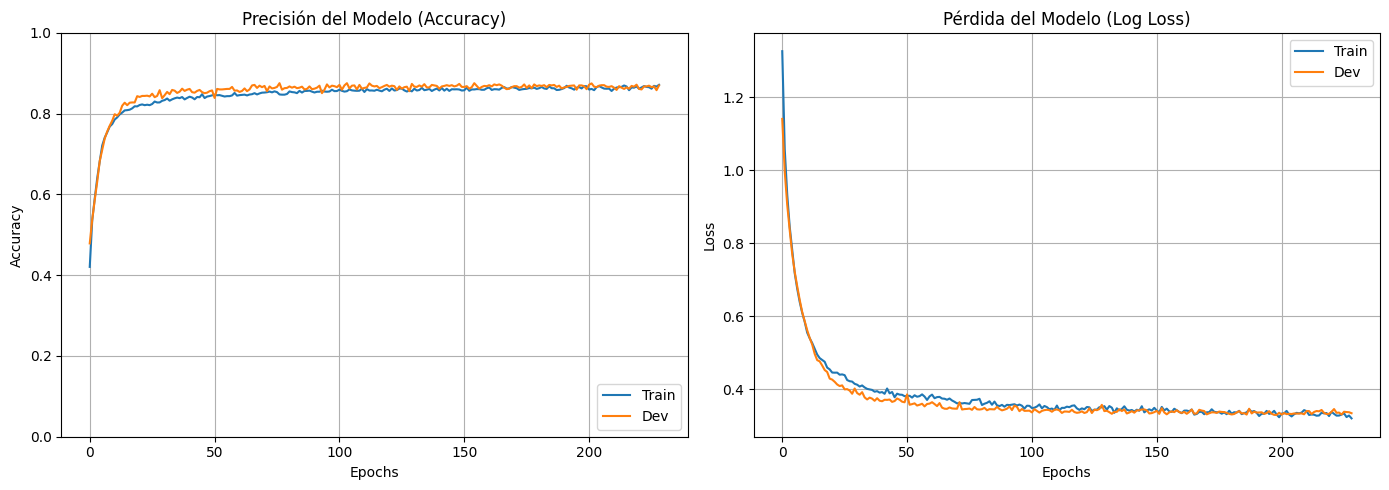

In [9]:
results = pd.DataFrame(history.history)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfica 1: Accuracy
ax1.plot(results['categorical_accuracy'],   label='Train', linewidth=1.5)
ax1.plot(results['val_categorical_accuracy'], label='Dev',   linewidth=1.5)
ax1.set_title('Precisión del Modelo (Accuracy)')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epochs')
ax1.legend(loc='lower right')
ax1.grid(True)
ax1.set_ylim(0, 1)

# Gráfica 2: Loss
ax2.plot(results['loss'],     label='Train', linewidth=1.5)
ax2.plot(results['val_loss'], label='Dev',   linewidth=1.5)
ax2.set_title('Pérdida del Modelo (Log Loss)')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.legend(loc='upper right')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [10]:
train_acc  = results['categorical_accuracy'].iloc[-1]
val_acc    = results['val_categorical_accuracy'].iloc[-1]
train_loss = results['loss'].iloc[-1]
val_loss   = results['val_loss'].iloc[-1]
gap        = train_acc - val_acc

print("━" * 45)
print("  MÉTRICAS FINALES DEL ENTRENAMIENTO")
print("━" * 45)
print(f"  Accuracy  Train : {train_acc:.4f}")
print(f"  Accuracy  Dev   : {val_acc:.4f}")
print(f"  Loss      Train : {train_loss:.4f}")
print(f"  Loss      Dev   : {val_loss:.4f}")
print("━" * 45)
print(f"  Brecha train-val: {gap:+.4f}")
if gap < 0:
    print("  [!] ATENCION: train_acc < val_acc — posible sobreregularizacion")
elif gap < 0.05:
    print("  [OK] Brecha controlada — modelo bien calibrado")
else:
    print("  [!] Brecha elevada — posible overfitting")
print("━" * 45)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  MÉTRICAS FINALES DEL ENTRENAMIENTO
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Accuracy  Train : 0.8713
  Accuracy  Dev   : 0.8698
  Loss      Train : 0.3206
  Loss      Dev   : 0.3347
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Brecha train-val: +0.0015
  [OK] Brecha controlada — modelo bien calibrado
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


## Evaluación en el conjunto de desarrollo

In [11]:
# Predicciones en dev
dev_probs        = model.predict(x_dev)
y_pred_dev       = np.argmax(dev_probs, axis=1)
y_true_dev       = np.argmax(t_dev, axis=1)
correct_dev      = np.sum(y_pred_dev == y_true_dev)

clean_names = [re.sub(r'np\.float\d+\((.*?)\)', r'\1', str(name)) for name in CLASS_NAMES]

print(f"\n[DEV SET] Predicciones exactas: {correct_dev} de {len(y_true_dev)} ({correct_dev/len(y_true_dev)*100:.2f}%)")
print("\n--- Reporte de Clasificación (Dev) ---")
print(classification_report(y_true_dev, y_pred_dev, target_names=clean_names))

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

[DEV SET] Predicciones exactas: 1400 de 1613 (86.79%)

--- Reporte de Clasificación (Dev) ---
                     precision    recall  f1-score   support

  Poor:[46.0, 62.0]       0.91      0.90      0.91       418
Interm:[63.0, 66.0]       0.79      0.81      0.80       402
  Good:[67.0, 71.0]       0.83      0.85      0.84       421
 Excel:[72.0, 94.0]       0.95      0.91      0.93       372

           accuracy                           0.87      1613
          macro avg       0.87      0.87      0.87      1613
       weighted avg       0.87      0.87      0.87      1613



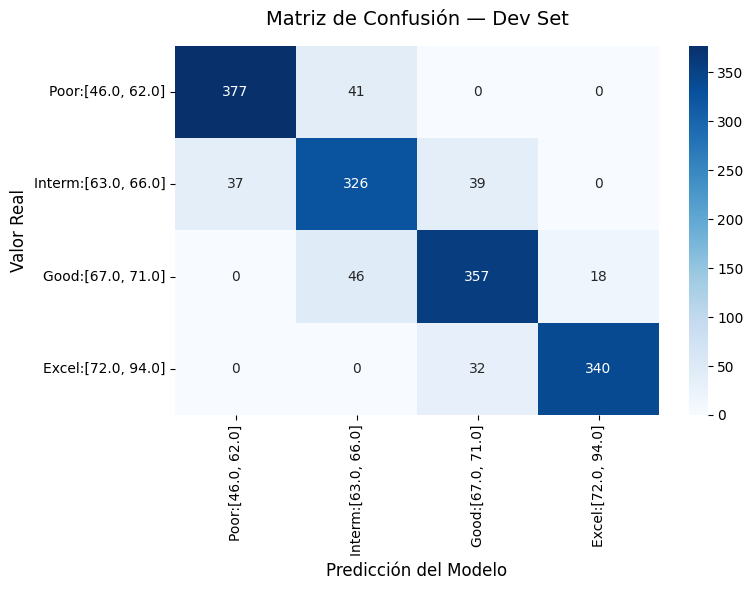

In [12]:
# Matriz de confusión — Dev Set
cm_dev = confusion_matrix(y_true_dev, y_pred_dev)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_dev, annot=True, fmt='d', cmap='Blues',
            xticklabels=clean_names, yticklabels=clean_names)
plt.title('Matriz de Confusión — Dev Set', fontsize=14, pad=15)
plt.xlabel('Predicción del Modelo', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)
plt.tight_layout()
plt.show()

## Evaluación en el conjunto de Test Final

In [13]:
print(f"Instancias en test final: {x_final_test.shape[0]}")
print()

# Evaluación con Keras (loss + accuracy)
test_loss, test_acc = model.evaluate(x_final_test, t_final_test, verbose=0)

print("━" * 45)
print("  MÉTRICAS — TEST FINAL (datos nuevos)")
print("━" * 45)
print(f"  Test Accuracy : {test_acc:.4f}  ({test_acc*100:.2f}%)")
print(f"  Test Loss     : {test_loss:.4f}")
print("━" * 45)

Instancias en test final: 1614

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  MÉTRICAS — TEST FINAL (datos nuevos)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Test Accuracy : 0.8606  (86.06%)
  Test Loss     : 0.3307
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


In [14]:
# Predicciones detalladas en test final
test_probs   = model.predict(x_final_test)
y_pred_test  = np.argmax(test_probs, axis=1)
y_true_test  = np.argmax(t_final_test, axis=1)
correct_test = np.sum(y_pred_test == y_true_test)

print(f"[TEST FINAL] Predicciones exactas: {correct_test} de {len(y_true_test)} ({correct_test/len(y_true_test)*100:.2f}%)")
print()
print("--- Reporte de Clasificación (Test Final) ---")
print(classification_report(y_true_test, y_pred_test, target_names=clean_names))

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step
[TEST FINAL] Predicciones exactas: 1389 de 1614 (86.06%)

--- Reporte de Clasificación (Test Final) ---
                     precision    recall  f1-score   support

  Poor:[46.0, 62.0]       0.88      0.90      0.89       446
Interm:[63.0, 66.0]       0.75      0.77      0.76       355
  Good:[67.0, 71.0]       0.86      0.86      0.86       458
 Excel:[72.0, 94.0]       0.94      0.91      0.93       355

           accuracy                           0.86      1614
          macro avg       0.86      0.86      0.86      1614
       weighted avg       0.86      0.86      0.86      1614



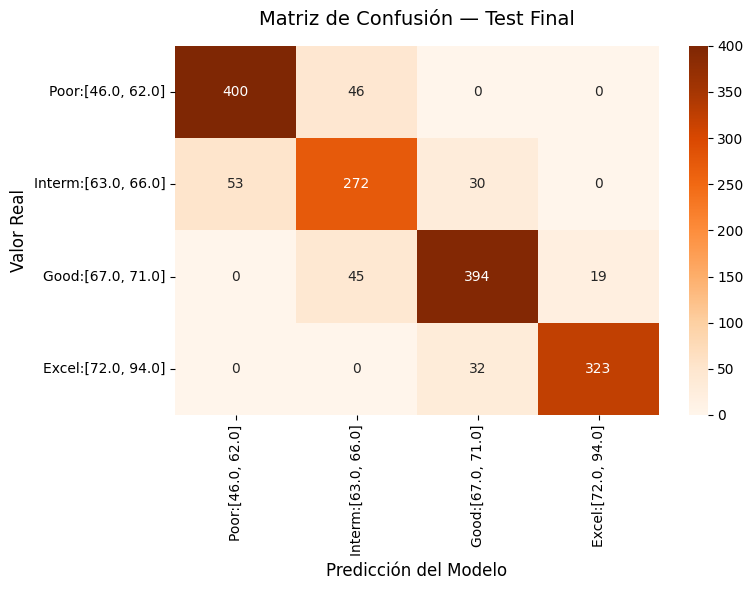

In [15]:
# Matriz de confusión — Test Final
cm_test = confusion_matrix(y_true_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges',
            xticklabels=clean_names, yticklabels=clean_names)
plt.title('Matriz de Confusión — Test Final', fontsize=14, pad=15)
plt.xlabel('Predicción del Modelo', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)
plt.tight_layout()
plt.show()

# Comparativa Dev vs Test Final

In [16]:
print("━" * 52)
print("  RESUMEN COMPARATIVO FINAL")
print("━" * 52)
print(f"  {'Conjunto':<20} {'Accuracy':>10} {'Loss':>10}")
print("  " + "-" * 42)
print(f"  {'Train': <20} {train_acc:>10.4f} {train_loss:>10.4f}")
print(f"  {'Dev / Validación':<20} {val_acc:>10.4f} {val_loss:>10.4f}")
print(f"  {'Test Final':<20} {test_acc:>10.4f} {test_loss:>10.4f}")
print("━" * 52)
print()
gap_dev_test = val_acc - test_acc
print(f"  Diferencia Dev vs Test : {gap_dev_test:+.4f}")
if abs(gap_dev_test) < 0.02:
    print("  [OK] Dev y Test son consistentes — modelo estable")
else:
    print("  [!] Diferencia notable entre Dev y Test — revisar distribución de datos")
print("━" * 52)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  RESUMEN COMPARATIVO FINAL
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Conjunto               Accuracy       Loss
  ------------------------------------------
  Train                    0.8713     0.3206
  Dev / Validación         0.8698     0.3347
  Test Final               0.8606     0.3307
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  Diferencia Dev vs Test : +0.0092
  [OK] Dev y Test son consistentes — modelo estable
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
